In [1]:
import sys, os, random
import csv
import json
import numpy as np
import openai
from datasets import load_dataset
from collections import defaultdict, OrderedDict
import shutil
import ast, re, copy
import uuid
from tqdm import tqdm
from mypy import api as mypyapi
import subprocess
import mistune

In [112]:
#temperature, top_p = 0.1, 1.0
temperature, top_p = 1.0, 0.7
#model = "gpt-4o-mini-2024-07-18"
model = "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd"
max_tokens = 2048
n = 10

In [113]:
#dataset_full = load_dataset("mbpp")

In [114]:
#round_n = 0
round_n = 6
#run_n = 0
run_n = 1
#is_test = False
is_test = True

In [115]:
train_or_test_str = "_train" if not is_test else "_test"

In [116]:
generations_filename = f"./alice{train_or_test_str}_round_{round_n}_{run_n}.jsonl"

In [117]:
# load generations

data = list()
with open(generations_filename, "r") as in_fs:
    for line in in_fs:
        example = json.loads(line.strip())
        new_example = defaultdict(list)
        new_example.update(example)
        new_example["bad_evaluations"] = []
        new_example["test_correct_programs"] = []
        for program in example["test_correct_programs"]:
            new_program = defaultdict(list)
            new_program.update(program)
            new_example["test_correct_programs"].append(new_program)
        data.append(new_example)

In [118]:
system_message = \
"""You are an expert computer scientist. Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input examples such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. If you determine that the two programs are not semantically equivalent, you also need to produce a diverging input example. Start by carefully analyzing the two programs and think of how an example would propagate through them from the input to the return value, considering whether it could elicit a different behaviors. 
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Equivalent?
Yes or No
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block, or nothing if the two programs are equivalent.
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs
"""

def user_message_fn_0(example, k):
    return f"""Entry point function: {example["function_name"]}

Program 1:
```python
{example["code"]}
```

Program 2:
```python
{example["test_correct_programs"][k]["program"]}
```"""

In [119]:
def example_to_openai_api_format(example, k):
    messages = [{"role": "system", "content": system_message}, 
                {"role": "user", "content": user_message_fn_0(example, k)}]
    rv = {
        "model": model,
        "messages": messages,
        "temperature": temperature,
        "top_p": top_p,
        "max_tokens": max_tokens,
        "n": n
#        "response_format": { "type": "json_object" }
    }
    return json.dumps(rv)

In [120]:
#generation_n = 0
generation_n = 1
round_n = 0
run_n = 0

In [121]:
emptytrain_or_test_str = "" if not is_test else "_test"
generation_str = "" if generation_n == 0 else f"_generation_{generation_n}"

In [122]:
example_to_openai_file_name_base = f"./evaluations{emptytrain_or_test_str}{generation_str}_round_{round_n}_run_{run_n}_to_openai.jsonl"
example_from_openai_file_name_base = f"./evaluations{emptytrain_or_test_str}{generation_str}_round_{round_n}_run_{run_n}_from_openai.jsonl"

In [123]:
example_from_openai_file_name_base

'./evaluations_test_generation_1_round_0_run_0_from_openai.jsonl'

In [124]:
print(user_message_fn_0(data[0], 0))
print(example_to_openai_api_format(data[0], 0))

Entry point function: remove_Occ

Program 1:
```python
def remove_Occ(s,ch): 
    for i in range(len(s)): 
        if (s[i] == ch): 
            s = s[0 : i] + s[i + 1:] 
            break
    for i in range(len(s) - 1,-1,-1):  
        if (s[i] == ch): 
            s = s[0 : i] + s[i + 1:] 
            break
    return s 
```

Program 2:
```python
def remove_Occ(s, ch):
    first_occurrence_removed = False
    for i in range(len(s)):
        if s[i] == ch:
            s = s[0:i] + s[i + 1:]
            first_occurrence_removed = True
    if first_occurrence_removed:
        s = s.rreplace(ch, '', 1)
    return s
```
{"model": "ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd", "messages": [{"role": "system", "content": "You are an expert computer scientist. Your task is to take two Python 3.10 programs and determine whether or not they are semantically equivalent. Two programs are semantically equivalent if there exists no diverging input exampl

In [125]:
# Load previous evaluations

previous_data = []
already_evaluated_program_pairs = set()
for prev_round_n in range(round_n):
    if not (os.path.isfile(f"./bob{train_or_test_str}{generation_str}_round_{prev_round_n}_{run_n}.jsonl")):
        continue
    with open(f"./bob{train_or_test_str}{generation_str}_round_{prev_round_n}_{run_n}.jsonl") as in_fs:
        for line in in_fs:
            example = json.loads(line.strip())
            previous_data.append(example)
            for x in example.get("test_correct_programs", []):
                program_pair = (example["code"], x["program"])
                already_evaluated_program_pairs.add(program_pair)

In [126]:
num_skipped_because_of_previous_eval = 0
with open(example_to_openai_file_name_base, "w") as out_fs:
    for example in data:
        if len(example["test_correct_evaluations"]) > 0:
            # already done, skip
            continue
        code = example["code"]
        already_done_program_set = set()
        for k in range(len(example["test_correct_programs"])):
            program = example["test_correct_programs"][k]["program"]
            if program not in already_done_program_set:
                already_done_program_set.add(program)
                if (code, program) not in already_evaluated_program_pairs:
                    print(example_to_openai_api_format(example, k), file=out_fs)
                else:
                    num_skipped_because_of_previous_eval += 1
print(f"Skipped because already evaluated in previous round: {num_skipped_because_of_previous_eval}")

Skipped because already evaluated in previous round: 0


In [127]:
filename = example_from_openai_file_name_base
#filename = example_with_errors_from_openai_file_name_base

bob_round_0_generations_oai = []

response_dict = defaultdict(list)
with open(filename, "r") as in_fs:
    for i, line in enumerate(in_fs):
        response = json.loads(line)
        inner_input = response[0]["messages"][1]["content"]
        for j, inner_output in enumerate(response[1]["choices"]):
            finish_reason = inner_output["finish_reason"]
            if finish_reason == "stop":
                generate_valid = True
            else:
                print(f"{i}, {j} {inner_input}, {finish_reason}")
                print(inner_output)
                print("")
                continue
            response_dict[inner_input].append(inner_output)

# reorder
new_response_dict = OrderedDict()
with open(example_to_openai_file_name_base, "r") as in_fs:
    for line in in_fs:
        original = json.loads(line)
        inner_input = original["messages"][1]["content"]
        new_response_dict[inner_input] = response_dict[inner_input]
bob_round_0_generations_oai = list(new_response_dict.items())

3301, 9 Entry point function: first_Digit

Program 1:
```python
def first_Digit(n) :  
    while n >= 10:  
        n = n / 10; 
    return int(n) 
```

Program 2:
```python
def first_Digit(n):
    while n >= 10:
        if n % 2 == 0:
            n = n * 2
        else:
            n = n / 10
    return int(n)
```, length
{'index': 9, 'message': {'role': 'assistant', 'content': "# Analysis\nLet's analyze the two programs step by step.\n\n## Program 1\n```python\ndef first_Digit(n) :  \n    while n >= 10:  \n        n = n / 10; \n    return int(n) \n```\n- This function takes a number `n` and repeatedly divides it by 10 until `n` is less than 10.\n- The final output is the integer part of `n`, which will be the first digit of the original number when `n` is treated as a positive integer.\n\n### Example Walkthrough\n- For `n = 1234`: \n  - 1234 / 10 = 123.4\n  - 123.4 / 10 = 12.34\n  - 12.34 / 10 = 1.234\n  - The loop stops as 1.234 < 10.\n  - The return value is `int(1.234)` which is `

In [128]:
bob_round_0_generations_oai[0][0]

"Entry point function: remove_Occ\n\nProgram 1:\n```python\ndef remove_Occ(s,ch): \r\n    for i in range(len(s)): \r\n        if (s[i] == ch): \r\n            s = s[0 : i] + s[i + 1:] \r\n            break\r\n    for i in range(len(s) - 1,-1,-1):  \r\n        if (s[i] == ch): \r\n            s = s[0 : i] + s[i + 1:] \r\n            break\r\n    return s \n```\n\nProgram 2:\n```python\ndef remove_Occ(s, ch):\n    first_occurrence_removed = False\n    for i in range(len(s)):\n        if s[i] == ch:\n            s = s[0:i] + s[i + 1:]\n            first_occurrence_removed = True\n    if first_occurrence_removed:\n        s = s.rreplace(ch, '', 1)\n    return s\n```"

In [129]:
# Extract generated program and diverging examples

#python_code_block_pattern = r"```python(.*?)```"
markdown = mistune.create_markdown(renderer='ast')

lodaded_responses = dict(bob_round_0_generations_oai)
for i, example in enumerate(data):
    if len(example["test_correct_evaluations"]) > 0:
        # already done, skip
        continue
    for k in range(len(example["test_correct_programs"])):
        program = example["test_correct_programs"][k]
        program["raw_eval_diverging_input_examples"] = dict()
        user_message = user_message_fn_0(example, k)
        entry_v = lodaded_responses.get(user_message, None)
        if entry_v is None:
            continue
        examples_set = set()
        for j, response in enumerate(entry_v):
            content = response["message"]["content"]
            try:
                parsed_markdown = markdown(content)
                # Find "Diverging input example"
                die_i = [i for i, e in enumerate(parsed_markdown) if (e['type'] == "heading") and (e["children"][0]["raw"] == "Diverging input example")][0]
                # Extract code blocks
                die_code_block = [e["raw"] for e in parsed_markdown[die_i:] if (e['type'] == "block_code") and ("attrs" in e) and (e["attrs"]["info"]=="python")][0]
            except:
                print(f"Error: {i}, {k}, {j} invalid markdown")
                #print(content)
                continue
            if die_code_block not in program["raw_eval_diverging_input_examples"]:
                program["raw_eval_diverging_input_examples"][die_code_block] = {"id": (k, j), "llm_response": content, "weight": 1}
            else:
                program["raw_eval_diverging_input_examples"][die_code_block]["weight"] += 1

Error: 139, 1, 6 invalid markdown
Error: 139, 4, 2 invalid markdown
Error: 196, 0, 9 invalid markdown
Error: 220, 0, 2 invalid markdown
Error: 220, 6, 2 invalid markdown
Error: 234, 4, 3 invalid markdown


In [130]:
# Alternatively, load precomputed

#in_filename = "./typed_examples_with_errors_9.jsonl"
#
#data = list()
#with open(in_filename, "r") as in_fs:
#    for line in in_fs:
#        example = json.loads(line.strip())
#        new_example = defaultdict(list)
#        new_example.update(example)
#        new_example["bad_programs"] = []
#        data.append(new_example)

In [131]:
# Parse and unparse

for i, example in enumerate(data):
    if len(example["test_correct_evaluations"]) > 0:
        # already done, skip
        continue
    for k, program in enumerate(example["test_correct_programs"]):
        program["eval_diverging_input_examples"] = dict()
        for die, die_dict in program["raw_eval_diverging_input_examples"].items():
            try:
                parsed_die = ast.parse(die, type_comments=True)
                program["eval_diverging_input_examples"][ast.unparse(parsed_die)] = die_dict
            except SyntaxError as e:
                print(f"Error in program {i}, {k}")
                print(e)
                error_message = f"{e.text}\n{str(e)}"
                example["bad_evals"].append({"diverging_input_example": die, 
                                             "error": error_message, 
                                             "error_type": "ast", 
                                             "id": die_dict["id"],
                                             "llm_response": die_dict["llm_response"]})

Error in program 13, 9
invalid decimal literal (<unknown>, line 2)


In [132]:
print(list(data[0]["test_correct_programs"][0].keys()))

['program', 'diverging_input_example', 'id', 'llm_response', 'raw_eval_diverging_input_examples', 'eval_diverging_input_examples']


In [133]:
data[0]["test_correct_programs"][0]["eval_diverging_input_examples"]

{"{'s': 'abcabc', 'ch': 'a'}": {'id': (0, 0),
  'llm_response': '# Analysis\nTo determine whether the two programs `remove_Occ` are semantically equivalent, we need to analyze how each program processes its inputs.\n\n## Program 1 Analysis\n```python\ndef remove_Occ(s, ch): \n    for i in range(len(s)): \n        if (s[i] == ch): \n            s = s[0 : i] + s[i + 1:] \n            break\n    for i in range(len(s) - 1, -1, -1):  \n        if (s[i] == ch): \n            s = s[0 : i] + s[i + 1:] \n            break\n    return s \n```\n1. The function iterates through the string `s` from the beginning to find the first occurrence of the character `ch`. When it finds it, it removes that occurrence and breaks out of the loop.\n2. Then, it iterates through the string from the end to find the last occurrence of `ch`. It removes that occurrence as well and breaks out of the loop.\n3. If `ch` is not found in `s`, the string remains unchanged.\n4. The function returns the modified string.\n\n##

In [134]:
print(list(data[0]["test_correct_programs"][0]["eval_diverging_input_examples"])[0])

{'s': 'abcabc', 'ch': 'a'}


In [135]:
tmp_program_dir = "./tmp_programs_eval/"

In [136]:
def generate_test_harness(example, base_module_name, test_entrypoint_name="test_main", timeout_min_seconds=2.5, timeout_max_seconds=5.0):
    function_name = example["function_name"]
    original_module_name = base_module_name+"_a"
    alt_module_name = base_module_name+"_b"
    timeout_seconds = random.uniform(timeout_min_seconds, timeout_max_seconds)
    rv = f"""
import multiprocessing
import pickle

def run_function(func, result_queue):
    try:
        rv = func()
        _ = pickle.dumps(rv)
        result_queue.put(("returned", rv))
    except BaseException as e:
        result_queue.put(("exception", e))

def run_with_timeout(func, timeout):
    result_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_function, args=(func, result_queue))
    process.start()
    process.join(timeout)
    if process.is_alive():
        process.terminate()
        return ("timeout", None)
    else:
        return result_queue.get()

import {original_module_name}
import {alt_module_name}

def main():
    timeout = {timeout_seconds}
    rv_a = run_with_timeout({original_module_name}.{test_entrypoint_name}, timeout)
    rv_b = run_with_timeout({alt_module_name}.{test_entrypoint_name}, timeout)
    assert(rv_a != rv_b)

if __name__ == "__main__":
    main()

    """
    return rv.strip()

def generate_test_module(program, function_name, diverging_input_example, test_entrypoint_name="test_main"):
    #diverging_input_example_str = f"{[k+'='+v for k, v in diverging_input_example.items()]}"
    rv = f"""
{program}

def {test_entrypoint_name}():
  return {function_name}(**{diverging_input_example})
"""
    return rv.strip()

In [137]:
print(generate_test_harness(data[42], "module_name"))
print("")
print(generate_test_module(data[42]["code"], 
                           data[42]["function_name"], 
                           list(data[42]["test_correct_programs"][0]["eval_diverging_input_examples"].keys())[0]))
print("")
print(generate_test_module(data[42]["test_correct_programs"][0]["program"], 
                           data[42]["function_name"], 
                           list(data[42]["test_correct_programs"][0]["eval_diverging_input_examples"].keys())[0]))

import multiprocessing
import pickle

def run_function(func, result_queue):
    try:
        rv = func()
        _ = pickle.dumps(rv)
        result_queue.put(("returned", rv))
    except BaseException as e:
        result_queue.put(("exception", e))

def run_with_timeout(func, timeout):
    result_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_function, args=(func, result_queue))
    process.start()
    process.join(timeout)
    if process.is_alive():
        process.terminate()
        return ("timeout", None)
    else:
        return result_queue.get()

import module_name_a
import module_name_b

def main():
    timeout = 4.015148084443023
    rv_a = run_with_timeout(module_name_a.test_main, timeout)
    rv_b = run_with_timeout(module_name_b.test_main, timeout)
    assert(rv_a != rv_b)

if __name__ == "__main__":
    main()

def check_Equality(str):
  if (str[0] == str[-1]):  
    return ("Equal") 
  else:  
    return ("Not Equal") 

def test_main()

In [138]:
# Full check

num_bad, num_total = 0, 0
num_test_checks = 0
num_type_failures, num_test_failures = 0, 0
sum_correctness = 0.0
for i in tqdm(range(len(data))):
    example = data[i]
    if len(example["test_correct_evaluations"]) > 0:
        # already done, skip
        continue
    for k, program in enumerate(example["test_correct_programs"]):
        if (example["code"], program["program"]) in already_evaluated_program_pairs:
            continue
        num_total += 1
        program["correct_eval_diverging_input_examples"] = dict()
        program["num_correct_eval_diverging_input_examples"] = 0.0
        weight_acc = 0.0
        if len(program["eval_diverging_input_examples"]) == 0:
            num_bad += 1
            continue
        for die, die_dict in program["eval_diverging_input_examples"].items():
            weight_acc += die_dict["weight"]
            module_name_base = "tmp_"+uuid.uuid4().hex+f"_{k}_x"
            original_module_name = module_name_base+"_a"
            alt_module_name = module_name_base+"_b"
            filename_original = tmp_program_dir+original_module_name+".py"
            filename_alt = tmp_program_dir+alt_module_name+".py"
            filename_harness = tmp_program_dir+module_name_base+"_harness.py"
            test_entrypoint_name = "test_"+uuid.uuid4().hex+"_main"
            with open(filename_original, "w") as out_fs:
                original_program = generate_test_module(example["code"], 
                                                        example["function_name"], 
                                                        die,
                                                        test_entrypoint_name)
                print(original_program, file=out_fs)
            with open(filename_alt, "w") as out_fs:
                alt_program = generate_test_module(program["program"], 
                                                   example["function_name"], 
                                                   die,
                                                   test_entrypoint_name)
                print(alt_program, file=out_fs)
            with open(filename_harness, "w") as out_fs:
                test_harness = generate_test_harness(example, module_name_base, test_entrypoint_name=test_entrypoint_name)
                print(test_harness, file=out_fs)
            # execute tests
            cmd = f"python -B {filename_harness} > {filename_harness}.out 2>&1"
            cmd_rv = os.system(cmd)
            num_test_checks += 1
            if cmd_rv != 0:
                with open(f"{filename_harness}.out", "r") as err_fs:
                    program_output = err_fs.read()
                    example["bad_programs"].append({"program": program["program"],
                                                    "diverging_input_example": die,
                                                    "error": program_output.strip(), 
                                                    "error_type": "test",
                                                    "id": die_dict["id"],
                                                    "llm_response": die_dict["llm_response"]})
                num_test_failures += 1
            else:
                program["correct_eval_diverging_input_examples"][die] = die_dict
                program["num_correct_eval_diverging_input_examples"] += die_dict["weight"]
                example["test_correct_evaluations"].append(program)
            os.remove(f"{filename_harness}.out")
            os.remove(filename_harness)
            os.remove(filename_alt)
            os.remove(filename_original)
        program["fraction_correct_eval_diverging_input_examples"] = program["num_correct_eval_diverging_input_examples"] / weight_acc
        sum_correctness += program["fraction_correct_eval_diverging_input_examples"]
        if len(example["test_correct_evaluations"]) == 0:
            num_bad += 1
frac_correct = (float(num_total) - num_bad) / num_total
avg_correctness = sum_correctness / num_total
print(f"Bad examples: {num_bad}/{num_total}. Correct fraction: {frac_correct}")
print(f"Test failures/checks: {num_test_failures}/{num_test_checks}")
print(f"Average correctness: {avg_correctness}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [27:39<00:00,  3.32s/it]

Bad examples: 8/3808. Correct fraction: 0.9978991596638656
Test failures/checks: 1651/14364
Average correctness: 0.9166518690809687


In [139]:
# Round 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 0/2925. Correct fraction: 1.0, Test failures/checks: 1010/11671, Average correctness: 0.9392427079093773
# Round 1 run 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 3/2920. Correct fraction: 0.998972602739726, Test failures/checks: 1335/12334, Average correctness: 0.9196481572080926
# Round 1 run 1 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 9/2903. Correct fraction: 0.9968997588701344, Test failures/checks: 1374/11904, Average correctness: 0.9087706204309748
# Round 1 run 2 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 11/2892. Correct fraction: 0.9961964038727524, Test failures/checks: 1347/11487, Average correctness: 0.9085996673911632
# Round 2 run 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 12/2475. Correct fraction: 0.9951515151515151, Test failures/checks: 1521/10407, Average correctness: 0.8702590989257677
# Round 3 run 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 7/1355. Correct fraction: 0.9948339483394834, Test failures/checks: 598/5669, Average correctness: 0.903014115855443
# Round 4 run 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 14/1864. Correct fraction: 0.9924892703862661, Test failures/checks: 1066/7867, Average correctness: 0.8838055214932912
# Round 5 run 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 12/1829. Correct fraction: 0.9934390377255331, Test failures/checks: 996/7793, Average correctness: 0.8834823869405621
# Round 6 run 0 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 25/1414. Correct fraction: 0.9823196605374823, Test failures/checks: 1285/6415, Average correctness: 0.8084074223748903
# Round 6 run 1 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 37/2320. Correct fraction: 0.9840517241379311, Test failures/checks: 2256/9852, Average correctness: 0.7598659003831406
# Generation 1 round 0 run 0 ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 3/2573. Correct fraction: 0.9988340458608628, Test failures/checks: 1722/9881, Average correctness: 0.869813817481912

# Test set Generation 0 Round 6 run 1 gpt-4o-mini-2024-07-18, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 17/3808. Correct fraction: 0.9955357142857143, Test failures/checks: 2021/15469, Average correctness: 0.883749124649863
# Test set Generation 1 Round 1 run 0 ft:gpt-4o-mini-2024-07-18:uedin:semantic-inequiv-bob-run-0-round-6-generation-0:AyS2gJFd, temperature = 1.0, top_p = 0.7, n = 10, Bad examples: 8/3808. Correct fraction: 0.9978991596638656, Test failures/checks: 1651/14364, Average correctness: 0.9166518690809687

In [140]:
print(data[42]["code"])
print(data[42]["test_correct_evaluations"][0]["program"])
print(data[42]["test_correct_evaluations"][0]["diverging_input_example"])

def check_Equality(str):
  if (str[0] == str[-1]):  
    return ("Equal") 
  else:  
    return ("Not Equal") 
def check_Equality(iterable):
    if len(iterable) == 0:
        return 'Empty'
    if iterable[0] == iterable[-1]:
        return 'Equal'
    else:
        return 'Not Equal'
{'iterable': [1, 2, 3, 1]}


In [141]:
#for i, example in enumerate(data):
#    for j, program in enumerate(example["test_correct_programs"]):
#        if program["fraction_correct_eval_diverging_input_examples"] < 1.0:
#            print(f"{i}, {j}")
#            print(example["code"])
#            print(program["program"])
#            print(program["diverging_input_example"])
#            print(program["fraction_correct_eval_diverging_input_examples"])
#            break

In [142]:
[i for i, example in enumerate(data) if len(example["test_correct_evaluations"]) == 0]

[153, 214]

In [143]:
out_filename = f"./bob{train_or_test_str}{generation_str}_round_{round_n}_{run_n}.jsonl"

In [144]:
out_filename

'./bob_test_generation_1_round_0_0.jsonl'

In [145]:
with open(out_filename, "w") as out_fs:
    for example in data:
        print(json.dumps(example), file=out_fs)

In [146]:
alice_bob_summary_datset = []
for example in data:
    correct_programs_summary_dict = dict()
    for program_dict in example["test_correct_programs"]:
        program = program_dict["program"]
        if program not in correct_programs_summary_dict:
            summary_dict = {"id": program_dict["id"],
                            "alice_diverging_input_examples": [program_dict["diverging_input_example"]],
                            "alice_llm_responses": [program_dict["llm_response"]],
                            "bob_diverging_input_examples": program_dict["correct_eval_diverging_input_examples"],
                            "bob_fraction_correct_eval_diverging_input_examples": program_dict["fraction_correct_eval_diverging_input_examples"]}
            if type(summary_dict["bob_fraction_correct_eval_diverging_input_examples"]) != float:
                summary_dict["bob_fraction_correct_eval_diverging_input_examples"] = 0.0
            correct_programs_summary_dict[program] = summary_dict
        else:
            correct_programs_summary_dict[program]["alice_diverging_input_examples"].append(program_dict["diverging_input_example"])
            correct_programs_summary_dict[program]["alice_llm_responses"].extend(program_dict["alice_llm_responses"])
            #x_dict = correct_programs_summary_dict[program]["bob_diverging_input_examples"]
            #y_dict = program_dict["correct_eval_diverging_input_examples"]
            #assert(x_dict.keys() == y_dict.keys())
            #for k, v_x in x_dict.items():
            #    v_y = y_dict[k]
            #    v_x, v_y = v_x.copy(), v_y.copy()
            #    del v_x["id"]
            #    del v_y["id"]
            #    assert(v_x == v_y)

    summary_dict = {"task_id": example["task_id"],
                    "text": example["text"],
                    "code": example["code"],
                    "function_name": example["function_name"],
                    "test_list": example["test_list"],
                    "test_setup_code": example["test_setup_code"],
                    "challenge_test_list": example["challenge_test_list"],
                    "user_message": example["user_message"],
                    "correct_programs_summary": correct_programs_summary_dict}
    alice_bob_summary_datset.append(summary_dict)

In [147]:
summary_filename = f"./alice_bob_summary{emptytrain_or_test_str}{generation_str}_round_{round_n}_run_{run_n}.jsonl"

In [148]:
with open(summary_filename, "w") as out_fs:
    for v in alice_bob_summary_datset:
        print(json.dumps(v), file=out_fs)

In [53]:
difficulty_array = []
for k in range(len(alice_bob_summary_datset)):
    row = [1.0-list(alice_bob_summary_datset[k]['correct_programs_summary'].values())[i]['bob_fraction_correct_eval_diverging_input_examples'] for i in range(len(alice_bob_summary_datset[k]['correct_programs_summary'].values()))]
    difficulty_array.extend(row)
difficulty_array = np.array(difficulty_array)
print(difficulty_array)

[0.  0.  0.7 ... 0.  0.  0. ]


In [54]:
import matplotlib.pyplot as plt

(array([1688.,  113.,   12.,  106.,   82.,  119.,   47.,    5.,   27.,
          46.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

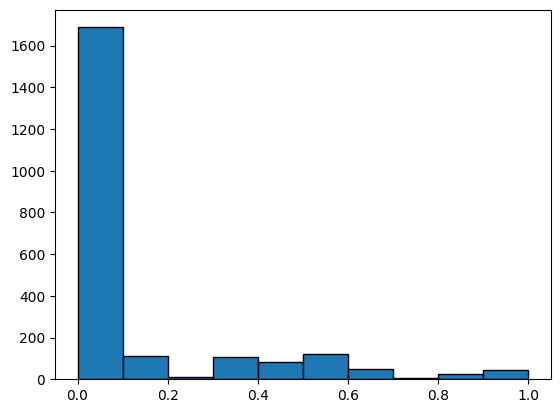

In [55]:
plt.hist(difficulty_array, bins=10, edgecolor='black')

In [56]:
sum((difficulty_array > 0.9) & (difficulty_array <= 1.0))

np.int64(24)

In [57]:
difficulty_array.mean()

np.float64(0.12154152083996181)

In [106]:
# Test set, untrained pre-gen 1

In [107]:
difficulty_array = []
for k in range(len(alice_bob_summary_datset)):
    row = [1.0-list(alice_bob_summary_datset[k]['correct_programs_summary'].values())[i]['bob_fraction_correct_eval_diverging_input_examples'] for i in range(len(alice_bob_summary_datset[k]['correct_programs_summary'].values()))]
    difficulty_array.extend(row)
difficulty_array = np.array(difficulty_array)
print(difficulty_array)

[0.1 0.1 0.1 ... 0.  0.6 0. ]


In [108]:
import matplotlib.pyplot as plt

(array([2705.,  144.,   11.,   93.,   85.,  119.,   41.,    9.,   67.,
          96.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

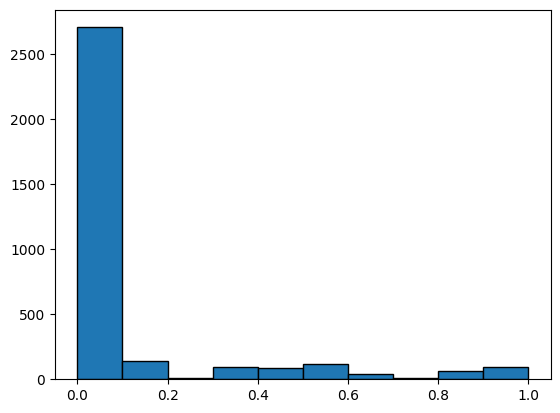

In [109]:
plt.hist(difficulty_array, bins=10, edgecolor='black')

In [110]:
sum((difficulty_array > 0.9) & (difficulty_array <= 1.0))

np.int64(62)

In [111]:
difficulty_array.mean()

np.float64(0.10787421694691723)

In [149]:
# Test set, trained gen 1

In [150]:
difficulty_array = []
for k in range(len(alice_bob_summary_datset)):
    row = [1.0-list(alice_bob_summary_datset[k]['correct_programs_summary'].values())[i]['bob_fraction_correct_eval_diverging_input_examples'] for i in range(len(alice_bob_summary_datset[k]['correct_programs_summary'].values()))]
    difficulty_array.extend(row)
difficulty_array = np.array(difficulty_array)
print(difficulty_array)

[0.  0.  0.  ... 0.  0.6 0. ]


In [151]:
import matplotlib.pyplot as plt

(array([2846.,  117.,   11.,   91.,   70.,   95.,   30.,    0.,   38.,
          72.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

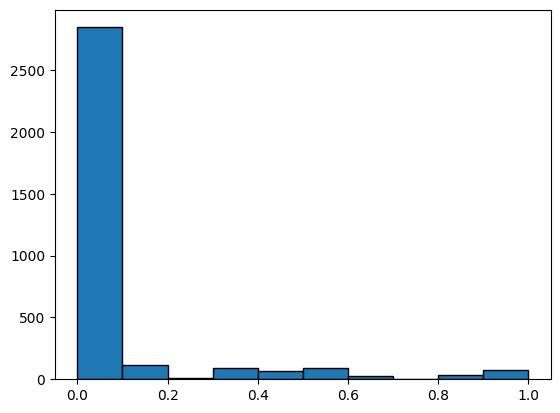

In [152]:
plt.hist(difficulty_array, bins=10, edgecolor='black')

In [153]:
sum((difficulty_array > 0.9) & (difficulty_array <= 1.0))

np.int64(38)

In [154]:
difficulty_array.mean()

np.float64(0.08166219207762235)

In [423]:
# Create finetuning files for Alice

In [479]:
finetuning_data_round = 2

In [480]:
# if previous round, load data
if finetuning_data_round < round_n:
    summary_filename = f"./alice_bob_summary_round_{finetuning_data_round}.jsonl"
    alice_bob_summary_datset = []
    with open(summary_filename, "r") as in_fs:
        for line in in_fs:
            alice_bob_summary_datset.append(json.loads(line.strip()))

In [481]:
alice_finetuning_examples_by_difficulty = defaultdict(list)
for k in range(len(alice_bob_summary_datset)):
    example = alice_bob_summary_datset[k]
    correct_programs_summary = example['correct_programs_summary']
    for generated_program, v in correct_programs_summary.items():
        difficulty = int(10.0 * (1-v['bob_fraction_correct_eval_diverging_input_examples']))
        x = {"code": example["code"],
             "function_name": example["function_name"]}
        assert (len(v['alice_llm_responses']) == 1)
        x['target_llm_response'] = v['alice_llm_responses'][0]
        x['difficulty_level'] = difficulty
        alice_finetuning_examples_by_difficulty[difficulty].append(x)

In [483]:
# Dataset rebalancing
# downsample the most common difficulty level (usually 0) to the second most common
# upsample the most rare difficulty level (usually 10) to the second most rare

#rebalanced_alice_finetuning_examples_by_difficulty = alice_finetuning_examples_by_difficulty.copy()
#difficulty_levels_sorted_by_freq = sorted([(d, len(v)) for d, v in alice_finetuning_examples_by_difficulty.items()], key=lambda x: x[1])
#if len(difficulty_levels_sorted_by_freq) > 2:
#    resampled_largest  =  random.sample(alice_finetuning_examples_by_difficulty[difficulty_levels_sorted_by_freq[-1][0]], difficulty_levels_sorted_by_freq[-2][1])
#    resampled_smallest = random.choices(alice_finetuning_examples_by_difficulty[difficulty_levels_sorted_by_freq[0][0]], k=difficulty_levels_sorted_by_freq[1][1])
#    rebalanced_alice_finetuning_examples_by_difficulty[difficulty_levels_sorted_by_freq[-1][0]] = resampled_largest
#    rebalanced_alice_finetuning_examples_by_difficulty[difficulty_levels_sorted_by_freq[0][0]] = resampled_smallest
#
#rebalanced_alice_finetuning_examples = []
#for v in rebalanced_alice_finetuning_examples_by_difficulty.values():
#    rebalanced_alice_finetuning_examples.extend(v)
#random.shuffle(rebalanced_alice_finetuning_examples)

In [484]:
def rebalance_dataset(dataset_by_difficulty, difficulty_level_theshold=5, easy_examples_fraction=0.1):
    rebalanced_dataset_by_difficulty = defaultdict(list)
    num_hard_examples = 0
    num_easy_examples = 0
    easy_examples = defaultdict(list)
    for d, v in dataset_by_difficulty.items():
        if d >= difficulty_level_theshold:
            num_hard_examples += len(v)
            rebalanced_dataset_by_difficulty[d] = v
        else:
            num_easy_examples += len(v)
    hard_examples_fraction = 1.0 - easy_examples_fraction
    num_easy_examples_to_add = int((easy_examples_fraction/hard_examples_fraction) * num_hard_examples)
    num_easy_examples_to_add = min(num_easy_examples_to_add, num_easy_examples)
    print(f"Original examples: {num_hard_examples + num_easy_examples}, easy: {num_easy_examples}, hard: {num_hard_examples}")
    print(f"Rebalanced examples: {num_hard_examples+num_easy_examples_to_add}, easy: {num_easy_examples_to_add}, hard: {num_hard_examples}")

    # go in a round robin way through difficulty levels
    d = difficulty_level_theshold - 1
    while (num_easy_examples_to_add > 0):
        if d < 0:
            d = difficulty_level_theshold - 1
        if len(easy_examples[d]) == 0:
            v = dataset_by_difficulty[d]
            if len(v) == 0:
                d -= 1
                continue
            v = v.copy()
            random.shuffle(v)
            easy_examples[d] = v
        example = easy_examples[d].pop()
        rebalanced_dataset_by_difficulty[d].append(example)
        num_easy_examples_to_add -= 1
        d -= 1

    rebalanced_dataset = []
    for v in rebalanced_dataset_by_difficulty.values():
        rebalanced_dataset.extend(v)
    random.shuffle(rebalanced_dataset)
    return rebalanced_dataset_by_difficulty, rebalanced_dataset

# More aggressive dataset rebalancing
# downsample examples of difficulty below 5 to 1/10 of the dataset

rebalanced_alice_finetuning_examples_by_difficulty, rebalanced_alice_finetuning_examples = rebalance_dataset(alice_finetuning_examples_by_difficulty)

Original examples: 2198, easy: 1932, hard: 266
Rebalanced examples: 295, easy: 29, hard: 266


In [485]:
rebalanced_difficulty_array = np.array([example["difficulty_level"] for example in rebalanced_alice_finetuning_examples])

In [486]:
rebalanced_difficulty_array.mean()

np.float64(6.606779661016949)

(array([ 5.,  6.,  6.,  6.,  6., 60., 48., 60., 37., 61.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

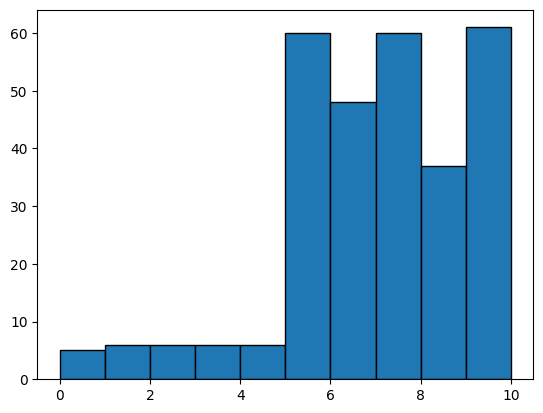

In [487]:
plt.hist(rebalanced_difficulty_array, bins=10, edgecolor='black')

In [488]:
_, rebalanced_alice_finetuning_examples_for_difficulty_prediction = rebalance_dataset(alice_finetuning_examples_by_difficulty, easy_examples_fraction=0.5)

Original examples: 2198, easy: 1932, hard: 266
Rebalanced examples: 532, easy: 266, hard: 266


In [489]:
finetuning_for_alice_system_message = \
"""You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.
The original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), so make sure that the difference you introduce are not very easy to understand. You will be given a difficulty level from 0 (easiest) to 10 (hardest) to target. E.g. difficulty level 0 means that an expert computer scientist in the bottom decile or above should be able to find a diverging example, difficulty level 9 means that only an expert computer scientist in the top decile should be able to find a diverging example, and difficulty level 10 means that only the top 1% or less of expert computer scientists should be able to find a diverging example.
Think step by step before writing your program. Use the following Markdown format, making sure that the following sections are delimited by level 1 headings, since they will have to be automatically parsed:
# Analysis
step by step analysis. This section can include sub-headings and code blocks
# Generated program
your program inside a Python code block. Do not change the name or signature of the entry point function
# Diverging input example
your diverging input example as a Python dictionary inside a Python code block
For instance, if the entry point function takes two parameters a and b and your diverging example is a="foo" and b=42, write:
```python
{
  "a": "foo",
  "b": 42
}
```
do not write the expected outputs
"""

def finetuning_for_alice_user_message_fn_0(example, difficulty_level=None):
    if difficulty_level == None:
        difficulty_level = example["difficulty_level"]
    return f"""Difficulty level: {difficulty_level}
Entry point function: {example["function_name"]}

```python
{example["code"]}
```"""

def finetuning_for_alice_assistant_message_fn_0(example):
    return example["target_llm_response"]

finetuning_for_alice_for_difficulty_prediction_user_message_1 = """Predict the difficulty level of the instance. Just write "Difficulty level: D" where D is your prediction, do not write anything else."""

def finetuning_for_alice_for_difficulty_prediction_assistant_message_fn_1(example):
    return f"""Difficulty level: {example["difficulty_level"]}"""

In [490]:
finetuning_for_alice_run_n = 0
#finetuning_for_alice_run_n = 1
#finetuning_for_alice_run_n = 2
finetuning_for_alice_filename = f"./finetuning_data_for_alice/finetuning_data_for_alice_{finetuning_data_round}_train_{finetuning_for_alice_run_n}.jsonl"

In [491]:
add_difficulty_prediction_examples = True

with open(finetuning_for_alice_filename, "w") as out_fs:
    for example in rebalanced_alice_finetuning_examples:
        messages = [{"role": "system", "content": finetuning_for_alice_system_message}, 
                    {"role": "user", "content": finetuning_for_alice_user_message_fn_0(example)},
                    {"role": "assistant", "content": finetuning_for_alice_assistant_message_fn_0(example)}]
        example_dict = {"messages": messages}
        print(json.dumps(example_dict), file=out_fs)
    if add_difficulty_prediction_examples:
        for example in rebalanced_alice_finetuning_examples_for_difficulty_prediction:
            messages = [{"role": "system", "content": finetuning_for_alice_system_message}, 
                        {"role": "user", "content": finetuning_for_alice_user_message_fn_0(example, difficulty_level="Any")},
                        {"role": "assistant", "content": finetuning_for_alice_assistant_message_fn_0(example), "weight": 0},
                        {"role": "user", "content": finetuning_for_alice_for_difficulty_prediction_user_message_1},
                        {"role": "assistant", "content": finetuning_for_alice_for_difficulty_prediction_assistant_message_fn_1(example)}]
            example_dict = {"messages": messages}
            print(json.dumps(example_dict), file=out_fs)

In [492]:
# Validate fine-tuning data files

data_path = finetuning_for_alice_filename

with open(data_path, 'r', encoding='utf-8') as f:
    finetune_dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(finetune_dataset))
print("First example:")
for message in finetune_dataset[0]["messages"]:
    print(message)

Num examples: 827
First example:
{'role': 'system', 'content': 'You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.\nThe original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), so

In [493]:
from openai import OpenAI

oai_key_file = "../oai_key"

if os.environ.get("OPENAI_API_KEY", "") == "":
    with open(oai_key_file, "r") as in_fs:
        os.environ["OPENAI_API_KEY"] = in_fs.read().strip()

In [494]:
# Upload fine-tuning data files to OpenAI

with open(finetuning_for_alice_filename, "rb") as in_fs:
    client = OpenAI()
    client.files.create(file=in_fs, purpose="fine-tune")

In [ ]:
for i, example in enumerate(data):
    if (len(example["test_correct_programs"]) > 0) and (example["raw_programs"][0].startswith("#")):
        print(data[i]["text"])
        print(data[i]["code"])
        print(data[i]["test_correct_programs"][0])
        print("=======\n")

In [422]:
for message in finetune_dataset[-1]["messages"]:
    for k,v in message.items():
        print(k)
        print(v)

role
system
content
You are an expert computer scientist. Your task is to take a Python 3.10 program and write a similar program which is not semantically equivalent, which means that there must exist at least a diverging input example such that the original program and your program either produce different outputs or exceptions, or one halts and the other one does not halt. In addition to a program, you need to produce a diverging input example. Start by carefully analyzing the original program and think of how an example would propagate through it from the input to the return value, considering how to modify the program in order to elicit a different behavior. Make sure that the return values or exceptions raised by your program are picklable.
The original program and your program will be used in a test to evaluate the skill of an expert computer scientist who will have to produce a diverging example (not necessarily the same as yours), so make sure that the difference you introduce 